In [52]:
from z3 import *
from itertools import product
from functools import reduce

s = Solver()

# --- aircraft variables ---
p1, a, p2, b, p3 = Ints('p1 a p2 b p3')
aircraft = [p1, a, p2, b, p3]

# --- explicit variable mappings ---
R  = {ac: Real(f"R_{ac}")  for ac in aircraft}
B  = {ac: Real(f"B_{ac}")  for ac in aircraft}
LT = {ac: Real(f"LT_{ac}") for ac in aircraft}
δ  = {(x, y): Real(f"δ_{x}_{y}") for x, y in product(aircraft, aircraft)}

# --- basic constraints ---
for ac in aircraft:
    s.add(R[ac] >= 0)
    s.add(LT[ac] >= 0)
    s.add(B[ac] >= 0)
    s.add(R[ac] >= B[ac])

for (x, y) in product(aircraft, aircraft):
    s.add(δ[(x, y)] >= 0)

# --- δ-identical a/b ---
for x_ in aircraft:
    s.add(δ[(a, x_)] == δ[(b, x_)])
    s.add(δ[(x_, a)] == δ[(x_, b)])

# --- zmax and T computation ---
def zmax(x, y):
    return If(x >= y, x, y)

def zmax_list(xs):
    return reduce(lambda a, b: zmax(a, b), xs)

def compute_T(seq):
    T = {seq[0]: R[seq[0]]}
    for i in range(1, len(seq)):
        preds = seq[:i]
        T[seq[i]] = zmax(R[seq[i]], zmax_list([T[x] + δ[(x, seq[i])] for x in preds]))
    return T

S1, S2 = [p1, a, p2, b, p3], [p1, b, p2, a, p3]
T1, T2 = compute_T(S1), compute_T(S2)

# --- ω weightings ---
ω1, ω2, ω3, ω4 = Reals('ω1 ω2 ω3 ω4')
W1, W2, α = Reals('W1 W2 alpha')

# --- constants ---
α = Real("α")
s.add(α == 2)

s.add(W1 >= 0, W2 >= 0)
s.add(ω1 >= 0, ω2 >= 0, ω3 >= 0, ω4 >= 0)
s.add(ω1 <= ω3, ω2 <= ω4)

# --- cost function ---
def C(t, lc):
    return If(t <= lc,
              RealVal(0),
              If(t <= lc + 300,
                 ω1 * (t - lc) + ω2,
                 ω3 * (t - lc) + ω4))

def term(i, T):
    return W1 * ((T[i] - B[i]) ** α) + W2 * C(T[i], LT[i])

# --- F(s): max over sequence ---
def F(seq, T):
    return zmax_list([term(i, T) for i in seq])

s.add(F(S1, T1) < F(S2, T2))

In [53]:

if s.check() == z3.sat:
    model = s.model()
    print("\nTheorem 4 holds SAT (counterexample found).\nSatisfying Model:")
    m = s.model()
    for d in m.decls():
        print(f" - {d.name()} = {m[d]}")
elif s.check() == z3.unsat:
    print("\nUNSAT — Theorem 4 holds: a before b cannot worsen hard-window compliance if s' is feasible.")
else:
    print("\nUNKOWN - Theorem 4 exceeds SMT decidable logic.")




Theorem 4 holds SAT (counterexample found).
Satisfying Model:
 - ω2 = 0
 - δ_b_p2 = 0
 - ω1 = 1/2
 - LT_b = 2
 - δ_p1_p2 = 0
 - W2 = 1
 - δ_p1_b = 0
 - B_p2 = 0
 - LT_p1 = 0
 - B_p1 = 0
 - R_p3 = 0
 - B_p3 = 0
 - ω4 = 0
 - δ_p2_b = 0
 - W1 = 0
 - LT_a = 0
 - B_b = 0
 - δ_p3_p3 = 0
 - LT_p2 = 0
 - R_a = 0
 - δ_p3_p2 = 0
 - δ_p1_p3 = 0
 - δ_p3_b = 0
 - LT_p3 = 2
 - R_p1 = 0
 - B_a = 0
 - δ_a_b = 1
 - δ_p2_p2 = 0
 - δ_p1_p1 = 0
 - δ_p2_p1 = 0
 - δ_b_p1 = 0
 - R_b = 0
 - R_p2 = 0
 - δ_p2_p3 = 0
 - δ_b_p3 = 0
 - ω3 = 1
 - δ_p3_p1 = 0
 - δ_b_b = 1
 - α = 2
 - δ_p3_a = 0
 - δ_a_p1 = 0
 - δ_a_a = 1
 - δ_a_p3 = 0
 - δ_p2_a = 0
 - δ_p1_a = 0
 - δ_a_p2 = 0
 - δ_b_a = 1


SAT, Generating Counterexample...


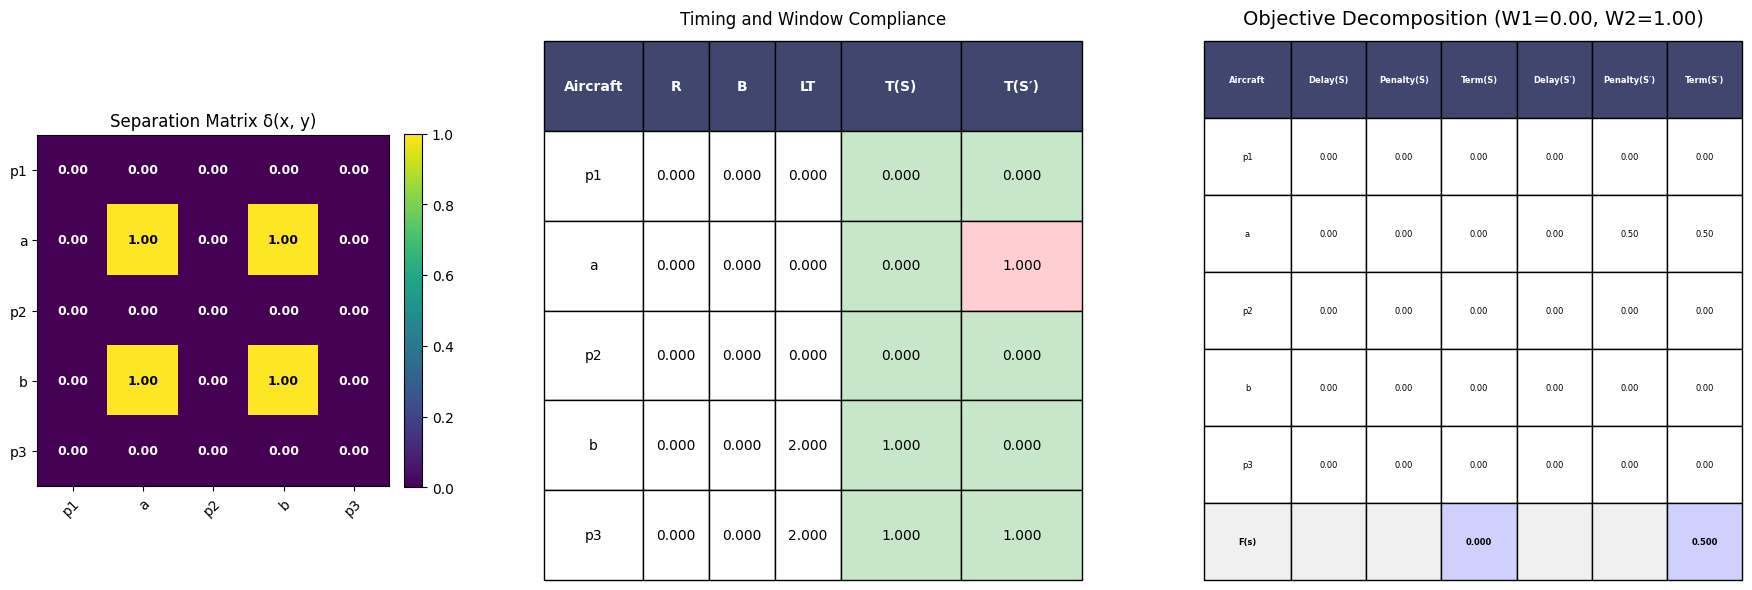

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.table import Table
from z3 import *

def z3_to_float(val):
    if is_rational_value(val):
        return val.numerator_as_long() / val.denominator_as_long()
    if is_algebraic_value(val):
        s = val.approx(20)
        if s.endswith("?"): s = s[:-1]
        return float(s)
    s = str(val)
    if s.endswith("?"): s = s[:-1]
    if "/" in s:
        num, den = s.split("/", 1)
        return float(num) / float(den)
    try:
        return float(s)
    except ValueError:
        return np.nan

if s.check() == sat:
    print("SAT, Generating Counterexample...")
    m = s.model()

    # --- helper to evaluate z3 expr as float ---
    def evalf(expr):
        return z3_to_float(m.evaluate(expr, model_completion=True))

    # --- reconstruct data ---
    data = []
    for ac in aircraft:
        r   = evalf(R[ac])
        b   = evalf(B[ac])
        lt  = evalf(LT[ac])
        t   = evalf(T1[ac])
        tp  = evalf(T2[ac])
        ok_s  = t  <= lt
        ok_sp = tp <= lt
        data.append({
            "Aircraft": str(ac),
            "R": r,
            "B": b,
            "LT": lt,
            "T(S)": t,
            "T(S′)": tp,
            "OK(S)": ok_s,
            "OK(S′)": ok_sp,
        })
    df = pd.DataFrame(data)

    # --- evaluate objective components ---
    W1v = evalf(W1)
    W2v = evalf(W2)
    ω1v, ω2v, ω3v, ω4v = [evalf(w) for w in (ω1, ω2, ω3, ω4)]

    def C_val(t, lc):
        if t <= lc:
            return 0
        elif t <= lc + 300:
            return ω1v * (t - lc) + ω2v
        else:
            return ω3v * (t - lc) + ω4v

    def term_val(i, T, B_, LT_):
        delay = W1v * (T - B_)
        penalty = W2v * C_val(T, LT_)
        return delay, penalty, delay + penalty

    def F_val(seq, T, B_, LT_):
        vals = [term_val(i, T[i], B_[i], LT_[i])[2] for i in seq]
        return max(vals)

    # Compute for S and S'
    term_data = []
    for ac in aircraft:
        t1, t2 = evalf(T1[ac]), evalf(T2[ac])
        b, lt = evalf(B[ac]), evalf(LT[ac])
        d1, p1, tot1 = term_val(ac, t1, b, lt)
        d2, p2, tot2 = term_val(ac, t2, b, lt)
        term_data.append({
            "Aircraft": str(ac),
            "Delay(S)": d1, "Penalty(S)": p1, "Term(S)": tot1,
            "Delay(S′)": d2, "Penalty(S′)": p2, "Term(S′)": tot2
        })
    df_terms = pd.DataFrame(term_data)

    FS  = F_val(S1, {ac: evalf(T1[ac]) for ac in aircraft},
                {ac: evalf(B[ac]) for ac in aircraft},
                {ac: evalf(LT[ac]) for ac in aircraft})
    FSp = F_val(S2, {ac: evalf(T2[ac]) for ac in aircraft},
                {ac: evalf(B[ac]) for ac in aircraft},
                {ac: evalf(LT[ac]) for ac in aircraft})

    # --- δ heatmap ---
    delta_matrix = np.array([
        [evalf(δ[(a_, b_)]) for b_ in aircraft]
        for a_ in aircraft
    ])
    labels = [str(a_) for a_ in aircraft]

    fig, (ax_heat, ax_table, ax_obj) = plt.subplots(
        1, 3,
        figsize=(22, 7),  # larger figure
        gridspec_kw={'width_ratios': [1, 1.4, 1.4]}
    )
    plt.subplots_adjust(wspace=0.25)  # less horizontal space between plots


    # --- (1) δ heatmap ---
    im = ax_heat.imshow(delta_matrix, cmap="viridis", interpolation="nearest")
    ax_heat.set_title("Separation Matrix δ(x, y)")
    ax_heat.set_xticks(np.arange(len(labels)))
    ax_heat.set_yticks(np.arange(len(labels)))
    ax_heat.set_xticklabels(labels)
    ax_heat.set_yticklabels(labels)
    plt.setp(ax_heat.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    for i in range(len(labels)):
        for j in range(len(labels)):
            val = delta_matrix[i, j]
            text_color = "white" if val < np.max(delta_matrix) / 2 else "black"
            ax_heat.text(j, i, f"{val:.2f}",
                         ha="center", va="center", color=text_color,
                         fontsize=9, fontweight='bold')
    fig.colorbar(im, ax=ax_heat, fraction=0.046, pad=0.04)

    # --- (2) Timing + window compliance ---
    ax_table.axis("off")
    tbl = Table(ax_table, bbox=[0, 0, 1, 1])
    col_labels = ["Aircraft", "R", "B", "LT", "T(S)", "T(S′)"]
    col_widths = [0.18, 0.12, 0.12, 0.12, 0.22, 0.22]
    n_rows = len(df)
    row_height = 1.0 / (n_rows + 1)

    # header
    for j, label in enumerate(col_labels):
        cell = tbl.add_cell(0, j, width=col_widths[j], height=row_height,
                            text=label, loc='center', facecolor='#40466e')
        cell.get_text().set_color('w')
        cell.get_text().set_weight('bold')

    for i, (_, row) in enumerate(df.iterrows(), start=1):
        vals = [row["Aircraft"], f"{row['R']:.3f}", f"{row['B']:.3f}",
                f"{row['LT']:.3f}", f"{row['T(S)']:.3f}", f"{row['T(S′)']:.3f}"]

        for j, val in enumerate(vals):
            facecolor = 'white'
            if col_labels[j] == "T(S)":
                facecolor = '#c8e6c9' if row["OK(S)"] else '#ffcdd2'
            elif col_labels[j] == "T(S′)":
                facecolor = '#c8e6c9' if row["OK(S′)"] else '#ffcdd2'

            cell = tbl.add_cell(i, j, width=col_widths[j], height=row_height,
                                text=val, loc='center', facecolor=facecolor)
            cell.get_text().set_color('black')

    ax_table.add_table(tbl)
    ax_table.set_title("Timing and Window Compliance", fontsize=12, pad=12)

    # --- (3) Objective decomposition ---
    ax_obj.axis("off")
    tbl2 = Table(ax_obj, bbox=[0, 0, 1, 1])
    col_labels2 = ["Aircraft",
                   "Delay(S)", "Penalty(S)", "Term(S)",
                   "Delay(S′)", "Penalty(S′)", "Term(S′)"]
    col_widths2 = [0.15, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13]
    n_rows2 = len(df_terms)
    row_height2 = 1.0 / (n_rows2 + 2)

    for j, label in enumerate(col_labels2):
        cell = tbl2.add_cell(0, j, width=col_widths2[j], height=row_height2,
                             text=label, loc='center', facecolor='#40466e')
        cell.get_text().set_color('w')
        cell.get_text().set_weight('bold')
        cell.get_text().set_fontsize(11)   # <— and here too

    for i, (_, row) in enumerate(df_terms.iterrows(), start=1):
        vals = [row["Aircraft"],
                f"{row['Delay(S)']:.2f}", f"{row['Penalty(S)']:.2f}", f"{row['Term(S)']:.2f}",
                f"{row['Delay(S′)']:.2f}", f"{row['Penalty(S′)']:.2f}", f"{row['Term(S′)']:.2f}"]

        for j, val in enumerate(vals):
            cell = tbl2.add_cell(i, j, width=col_widths2[j], height=row_height2,
                          text=val, loc='center', facecolor='white')
            cell.get_text().set_fontsize(11)   # <— and here too


    # summary row for F(S), F(S′)
    summary_vals = ["F(s)", "", "", f"{FS:.3f}", "", "", f"{FSp:.3f}"]
    for j, val in enumerate(summary_vals):
        cell = tbl2.add_cell(n_rows2+1, j, width=col_widths2[j], height=row_height2,
                             text=val, loc='center',
                             facecolor='#d0d0ff' if j in (3,6) else '#f0f0f0')
        cell.get_text().set_weight('bold')
        cell.get_text().set_fontsize(11)   # <— and here too

    ax_obj.add_table(tbl2)
    ax_obj.set_title(f"Objective Decomposition (W1={W1v:.2f}, W2={W2v:.2f})",
                     fontsize=14, pad=12)

    plt.show()
else:
    print("UNSAT or UNKNOWN — nothing to visualise.")
